In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import math
import pickle

In [80]:
df = pd.read_csv('/content/train_s3TEQDk.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


Train Data

ID : Unique Identifier for a row

Gender : Gender of the Customer

Age : Age of the Customer (in Years)

Region_Code : Code of the Region for the customers

Occupation : Occupation Type for the customer

Channel_Code : Acquisition Channel Code for the Customer  (Encoded)

Vintage : Vintage for the Customer (In Months)

Credit_Product : If the Customer has any active credit product (Home loan,Personal loan, Credit Card etc.)

Avg_Account_Balance : Average Account Balance for the Customer in last 12 Months

Is_Active : If the Customer is Active in last 3 Months

Is_Lead(Target) : If the Customer is interested for the Credit Card
                  <br>0 : Customer is not interested<br>
                  1 : Customer is interested

In [81]:
df1 = df.copy()

In [16]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


<h1>VECTORIZATION

In [83]:
def tfidf(data_col, data_tr_col):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features = 50)
    vectorizer.fit(data_tr_col)
    return vectorizer.transform(data_col).todense(), vectorizer.get_feature_names(), vectorizer.idf_

 
def one_hot_encoding(col_tr, col):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(max_features = 50)
    vectorizer.fit(col_tr)
    return vectorizer.transform(col).todense()

def word2vec(col, tfidf_feature_names, idf_val):
    from gensim.models import Word2Vec
    list_of_sentences=[]
    for sent in col:
      list_of_sentences.append(sent.split())
    W2V_model = Word2Vec(list_of_sentences,min_count=1,size=50,workers=5)
    #print(W2V_model.wv.most_similar('joy'))
    
    dictionary = dict(zip(tfidf_feature_names, list(idf_val)))
    tfidf_words = tfidf_feature_names
    W2V_words = W2V_model.wv.vocab
    sentence_vec = np.zeros(50)
    tfidf_w2v_vec=[]
    for sent in list_of_sentences:
      sentence_vec = np.zeros(50)
      for word in sent:
        if word in W2V_words and word in tfidf_words:
          vec = W2V_model.wv[word]
          tfidf_val = dictionary[word]*(sent.count(word)/len(sent))
          sentence_vec+=vec*tfidf_val
      tfidf_w2v_vec.append(sentence_vec)
    return tfidf_w2v_vec


def normalize(data,data_tr,feature):
  from sklearn.preprocessing import StandardScaler
  norm = StandardScaler()
  norm.fit(np.array(data_tr[feature]).reshape(-1,1))

  return norm.transform(np.array(data[feature]).reshape(-1,1))

def preprocessing(data):
  tar  = data['Is_Lead'].values
  data.drop('ID',axis=1,inplace=True)
  if df['Credit_Product'].isna().any():
    null_rows = df[df['Credit_Product'].isna()]
    data.dropna(inplace=True)
    tar_without_nan  = data['Is_Lead'].values
    return data, tar_without_nan, null_rows
  else:
    return data, tar, None


In [84]:
data_without_nan ,tar_without_nan, null_data = preprocessing(df)
data_without_nan

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...
245719,Female,38,RG280,Salaried,X2,13,Yes,354665,No,0
245721,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,Female,28,RG273,Salaried,X1,31,No,407504,No,0


<h1>Missing Value Imputation using ANN

In [85]:
from sklearn.model_selection import train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(data_without_nan.drop(['Credit_Product','Is_Lead'],axis=1),data_without_nan['Credit_Product'],test_size=0.25, random_state=52)


In [86]:
#train tfidf

gender_tfidf_tr, gender_features_tr, gender_idf_tr = tfidf(X_tr['Gender'],X_tr['Gender'])
Region_Code_tr, Region_Code_features_tr, Region_Code_idf_tr = tfidf(X_tr['Region_Code'], X_tr['Region_Code'])
Occupation_tr, Occupation_features_tr, Occupation_idf_tr = tfidf(X_tr['Occupation'], X_tr['Occupation'])
Channel_Code_tr, Channel_Code_features_tr, Channel_Code_idf_tr = tfidf(X_tr['Channel_Code'], X_tr['Channel_Code'])
Is_Active_tr, Is_Active_features_tr, Is_Active_idf_tr = tfidf(X_tr['Is_Active'], X_tr['Is_Active'])

age_normal_tr = normalize(X_tr, X_tr, 'Age')
vin_normal_tr = normalize(X_tr, X_tr, 'Vintage')
ac_bal_normal_tr = normalize(X_tr, X_tr, 'Avg_Account_Balance')

#test tfidf

gender_tfidf_test, gender_features_test, gender_idf_test = tfidf(X_test['Gender'],X_tr['Gender'])
Region_Code_test, Region_Code_features_test, Region_Code_idf_test = tfidf(X_test['Region_Code'], X_tr['Region_Code'])
Occupation_test, Occupation_features_test, Occupation_idf_test = tfidf(X_test['Occupation'], X_tr['Occupation'])
Channel_Code_test, Channel_Code_features_test, Channel_Code_idf_test = tfidf(X_test['Channel_Code'], X_tr['Channel_Code'])
Is_Active_test, Is_Active_features_test, Is_Active_idf_test = tfidf(X_test['Is_Active'], X_tr['Is_Active'])

age_normal_test = normalize(X_test, X_tr, 'Age')
vin_normal_test = normalize(X_test, X_tr, 'Vintage')
ac_bal_normal_test = normalize(X_test, X_tr, 'Avg_Account_Balance')




In [87]:
imp_tr = np.column_stack((gender_tfidf_tr,
                          Region_Code_tr, 
                          Occupation_tr,
                          Channel_Code_tr, 
                          Is_Active_tr,
                          age_normal_tr,
                          vin_normal_tr,
                          ac_bal_normal_tr
                         ))
                        


imp_test = np.column_stack((gender_tfidf_test,
                          Region_Code_test, 
                          Occupation_test,
                          Channel_Code_test, 
                          Is_Active_test,
                          age_normal_test,
                          vin_normal_test,
                          ac_bal_normal_test
                          ))
                        

In [88]:
print(imp_tr.shape,imp_test.shape)

(162300, 50) (54100, 50)


In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(imp_tr)
imp_tr = scaler.transform(imp_tr)
imp_test = scaler.transform(imp_test)

<h1>IMPUTATION USING SEQUENTIAL DENSE MODEL

In [90]:
import tensorflow as tf
import keras
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential

In [14]:
y_tr = tf.keras.utils.to_categorical(np.array([1 if i=="Yes" else 0 for i in y_tr]))
y_test = tf.keras.utils.to_categorical(np.array([1 if i=="Yes" else 0 for i in y_test]))

In [15]:
model = Sequential()
model.add(Dense(64, activation="relu", input_dim=(imp_tr.shape[1])))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(2, activation="relu"))
model.add(Dense(2, activation="softmax"))

auc = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, num_labels=None, label_weights=None,
    from_logits=False
)
model.compile(optimizer=Adam(lr=1e-4), loss="categorical_crossentropy", metrics=["accuracy",auc])

model.summary()
history = model.fit(imp_tr, 
                    y_tr, 
                    batch_size = 32,
                    epochs=10, 
                    validation_data=(imp_test, y_test), 
                    callbacks=[ReduceLROnPlateau(patience=3, verbose=1, min_lr=1e-6), 
                               EarlyStopping(patience=5, verbose=1)])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 6

In [ ]:
null_data.drop(['Credit_Product','Is_Lead'],axis=1,inplace=True)

In [18]:
null_data

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Avg_Account_Balance,Is_Active
6,Male,62,RG282,Other,X3,20,1056750,Yes
15,Male,33,RG268,Self_Employed,X2,69,517063,Yes
31,Female,32,RG279,Salaried,X4,15,1072850,Yes
36,Female,41,RG268,Self_Employed,X3,62,962383,No
40,Female,63,RG254,Other,X3,103,1249319,Yes
...,...,...,...,...,...,...,...,...
245684,Female,51,RG281,Entrepreneur,X3,99,552992,No
245694,Female,50,RG277,Self_Employed,X2,92,1385124,No
245699,Male,53,RG254,Other,X2,19,1141825,Yes
245714,Female,46,RG268,Self_Employed,X2,19,993195,No


In [199]:
X_tr

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Avg_Account_Balance,Is_Active
93380,Male,53,RG284,Self_Employed,X2,98,1175173,Yes
227468,Male,61,RG283,Self_Employed,X3,13,741539,No
139526,Female,38,RG273,Self_Employed,X2,26,391582,No
161330,Female,27,RG256,Other,X1,31,1617939,No
7622,Female,38,RG268,Salaried,X1,27,1581120,Yes
...,...,...,...,...,...,...,...,...
66188,Male,47,RG279,Self_Employed,X2,49,317552,No
146567,Male,44,RG268,Self_Employed,X1,61,492330,Yes
79301,Female,66,RG283,Other,X3,57,616850,Yes
64566,Male,26,RG256,Salaried,X1,21,1157712,Yes


In [19]:
gender_tfidf_null, gender_features_null, gender_idf_null = tfidf(null_data['Gender'],X_tr['Gender'])
Region_Code_null, Region_Code_features_null, Region_Code_idf_null = tfidf(null_data['Region_Code'], X_tr['Region_Code'])
Occupation_null, Occupation_features_null, Occupation_idf_null = tfidf(null_data['Occupation'], X_tr['Occupation'])
Channel_Code_null, Channel_Code_features_null, Channel_Code_idf_null = tfidf(null_data['Channel_Code'], X_tr['Channel_Code'])
Is_Active_null, Is_Active_features_null, Is_Active_idf_null = tfidf(null_data['Is_Active'], X_tr['Is_Active'])

age_normal_null = normalize(null_data, X_tr, 'Age')
vin_normal_null = normalize(null_data, X_tr, 'Vintage')
ac_bal_normal_null = normalize(null_data, X_tr, 'Avg_Account_Balance')



In [20]:
null_data_vec = np.column_stack((gender_tfidf_null,
                          Region_Code_null, 
                          Occupation_null,
                          Channel_Code_null, 
                          Is_Active_null,
                          age_normal_null,
                          vin_normal_null,
                          ac_bal_normal_null
                         ))
                        

In [ ]:
null_pred = [np.argmax(i) for i in model.predict(null_data_vec)]
null_pred 

In [91]:
#pickle.dump(null_pred,open('/content/drive/MyDrive/Data/null_pred.pkl','wb'))
null_pred = pickle.load(open('/content/drive/MyDrive/Data/null_pred.pkl','rb'))

In [92]:
null_pred= pd.DataFrame(null_pred,columns=['Credit_Product'])
print(null_pred[null_pred.Credit_Product==1].count(),null_pred[null_pred.Credit_Product==0].count())

Credit_Product    19216
dtype: int64 Credit_Product    10109
dtype: int64


In [93]:
a = pd.concat((data_without_nan['Credit_Product'] , null_pred['Credit_Product']),axis=0)

In [94]:
for i,val in enumerate(a.values):
  if val == 'Yes' or val == 1:
    a.iloc[i] = 1.0
  else:
    a.iloc[i] = 0.0


In [207]:
a.shape

(245725,)

In [95]:
df1['Credit_Product'] = a.values
df1

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,0,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,0,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,0,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,0,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,0,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,1,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,1,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,0,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,1,407504,No,0


<h1>Feature Selection using Gradient Boosting

In [96]:
feat_data = df1.copy()
feat_target = feat_data['Is_Lead']
feat_data.drop(['ID','Is_Lead'],axis=1,inplace=True)

In [97]:
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
feat_data['Gender']  = lab_enc.fit_transform(feat_data['Gender'])
feat_data['Region_Code']  = lab_enc.fit_transform(feat_data['Region_Code'])
feat_data['Occupation']  = lab_enc.fit_transform(feat_data['Occupation'])
feat_data['Channel_Code']  = lab_enc.fit_transform(feat_data['Channel_Code'])
feat_data['Is_Active']  = lab_enc.fit_transform(feat_data['Is_Active'])

In [98]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat_data = scaler.fit_transform(feat_data)

In [99]:
feat_data.shape

(245725, 9)

In [100]:
import warnings
warnings.simplefilter("ignore")
from sklearn.ensemble import GradientBoostingClassifier
gbdt= GradientBoostingClassifier()
results = gbdt.fit(feat_data,feat_target.values)


In [101]:
feat_importance = pd.DataFrame(results.feature_importances_,index=['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code','Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active'])
feat_importance

,0
Gender,0.001011
Age,0.155361
Region_Code,0.002325
Occupation,0.208727
Channel_Code,0.150545
Vintage,0.466872
Credit_Product,0.000000
Avg_Account_Balance,0.004826
Is_Active,0.010333


In [102]:
df1.drop(['ID','Gender','Region_Code','Credit_Product','Avg_Account_Balance'],axis=1,inplace=True)

In [103]:
df1.head()

,Age,Occupation,Channel_Code,Vintage,Is_Active,Is_Lead
0,73,Other,X3,43,No,0
1,30,Salaried,X1,32,No,0
2,56,Self_Employed,X3,26,Yes,0
3,34,Salaried,X1,19,No,0
4,30,Salaried,X1,33,No,0


<h1>Data Visualization

In [50]:
def check_imbalance(data,cat_col):
  plt.figure(figsize=(6,5))
  plt.title('Checking imbalance in '+str(cat_col))
  sns.countplot(data[cat_col])
  plt.grid(True)
  plt.show()

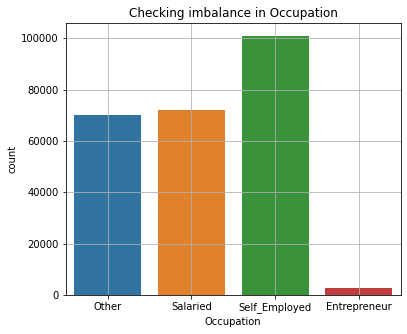

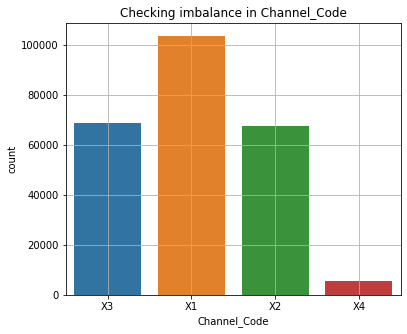

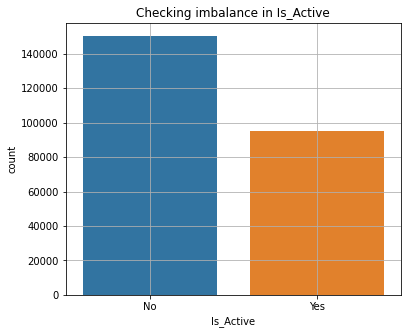

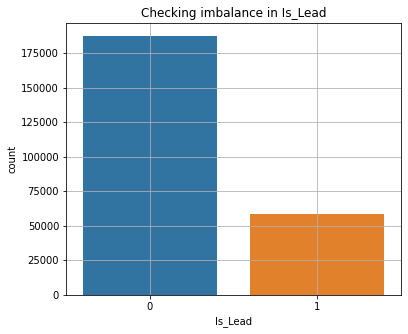

In [53]:
for col in ['Occupation','Channel_Code','Is_Active','Is_Lead']:
  check_imbalance(df1,col)


<h2><I>We can clearly detect unbalance in the target dataset. So we can under sample the dataset to make it more balanced.

In [104]:
df1.columns

Index(['Age', 'Occupation', 'Channel_Code', 'Vintage', 'Is_Active', 'Is_Lead'], dtype='object')

<h1>Outlier Detection

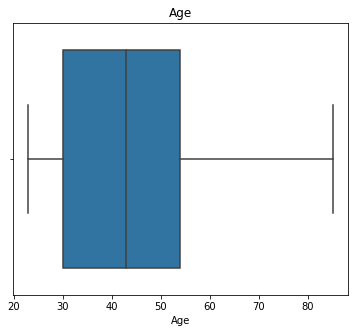

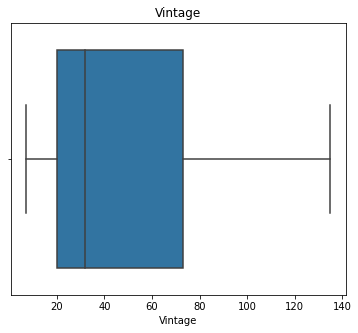

In [105]:
def distribution(col):
  plt.figure(figsize=(6,5))
  plt.title(col)
  sns.boxplot(df1[col])
  plt.show()

for col in ['Age','Vintage']:
  distribution(col)  

In [106]:
pickle.dump(df1,open('/content/drive/MyDrive/Data/filled_data.pkl','wb'))

In [108]:
#train tfidf

Occupation_tr, Occupation_features_tr, Occupation_idf_tr = tfidf(X_tr['Occupation'], X_tr['Occupation'])
Channel_Code_tr, Channel_Code_features_tr, Channel_Code_idf_tr = tfidf(X_tr['Channel_Code'], X_tr['Channel_Code'])
Is_Active_tr, Is_Active_features_tr, Is_Active_idf_tr = tfidf(X_tr['Is_Active'], X_tr['Is_Active'])

age_normal_tr = normalize(X_tr, X_tr, 'Age')
vin_normal_tr = normalize(X_tr, X_tr, 'Vintage')

#test tfidf

Occupation_test, Occupation_features_test, Occupation_idf_test = tfidf(X_test['Occupation'], X_tr['Occupation'])
Channel_Code_test, Channel_Code_features_test, Channel_Code_idf_test = tfidf(X_test['Channel_Code'], X_tr['Channel_Code'])
Is_Active_test, Is_Active_features_test, Is_Active_idf_test = tfidf(X_test['Is_Active'], X_tr['Is_Active'])

age_normal_test = normalize(X_test, X_tr, 'Age')
vin_normal_test = normalize(X_test, X_tr, 'Vintage')



unsampled_tr = np.column_stack((
                          Occupation_tr,
                          Channel_Code_tr, 
                          Is_Active_tr,
                          age_normal_tr,
                          vin_normal_tr
                         ))
                        


unsampled_test = np.column_stack(( 
                          Occupation_test,
                          Channel_Code_test, 
                          Is_Active_test,
                          age_normal_test,
                          vin_normal_test))
                        

<h1>Undersampling

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(unsampled_tr)
unsampled_tr= scaler.transform(unsampled_tr)
unsampled_test = scaler.transform(unsampled_test)

In [110]:
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1)
# transform the dataset
x_uns_tr, y_uns_tr = undersample.fit_resample(unsampled_tr,y_tr)

In [118]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_uns_tr = encoder.fit_transform(y_uns_tr)
y_uns_tr.shape

(108086,)

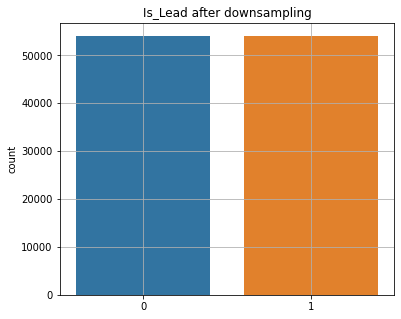

In [119]:
plt.figure(figsize=(6,5))
plt.title('Is_Lead after downsampling')
sns.countplot(y_uns_tr)
plt.grid(True)
plt.show()

<h2>Correlation Matrix

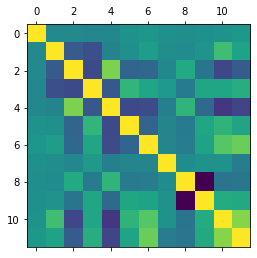

In [113]:
plt.matshow(pd.DataFrame(unsampled_tr).corr())
plt.show()

<h1>Baseline Model

<h2>Logistic regression

In [123]:
encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)
y_test.shape

(54100,)

TRAINING DATA ROC SCORE === 0.6994800436689304  ,LEARNING RATE ===  1e-07
TESTING DATA ROC SCORE === 0.6310358571868266  ,LEARNING RATE ===  1e-07
TRAINING DATA ACCURACY SCORE === 0.6994800436689304  ,LEARNING RATE ===  1e-07
TESTING DATA ACCURACY SCORE === 0.6053234750462108  ,LEARNING RATE ===  1e-07


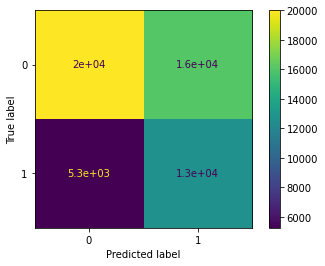

TRAINING DATA ROC SCORE === 0.7023758858686601  ,LEARNING RATE ===  1e-06
TESTING DATA ROC SCORE === 0.632471375807941  ,LEARNING RATE ===  1e-06
TRAINING DATA ACCURACY SCORE === 0.7023758858686602  ,LEARNING RATE ===  1e-06
TESTING DATA ACCURACY SCORE === 0.605083179297597  ,LEARNING RATE ===  1e-06


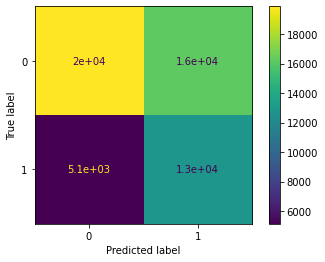

TRAINING DATA ROC SCORE === 0.7035508761541734  ,LEARNING RATE ===  1e-05
TESTING DATA ROC SCORE === 0.6338850415512465  ,LEARNING RATE ===  1e-05
TRAINING DATA ACCURACY SCORE === 0.7035508761541736  ,LEARNING RATE ===  1e-05
TESTING DATA ACCURACY SCORE === 0.6067467652495379  ,LEARNING RATE ===  1e-05


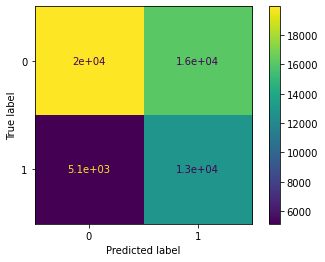

TRAINING DATA ROC SCORE === 0.708047295671965  ,LEARNING RATE ===  0.0001
TESTING DATA ROC SCORE === 0.6421186518928901  ,LEARNING RATE ===  0.0001
TRAINING DATA ACCURACY SCORE === 0.7080472956719649  ,LEARNING RATE ===  0.0001
TESTING DATA ACCURACY SCORE === 0.6128280961182995  ,LEARNING RATE ===  0.0001


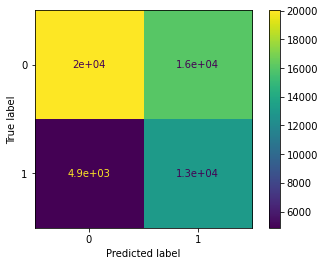

TRAINING DATA ROC SCORE === 0.7084821345965249  ,LEARNING RATE ===  0.001
TESTING DATA ROC SCORE === 0.6472688519544476  ,LEARNING RATE ===  0.001
TRAINING DATA ACCURACY SCORE === 0.708482134596525  ,LEARNING RATE ===  0.001
TESTING DATA ACCURACY SCORE === 0.6202218114602588  ,LEARNING RATE ===  0.001


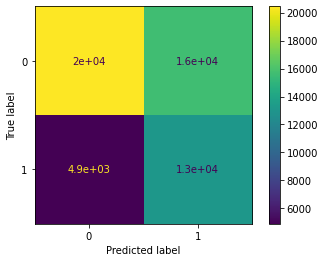

TRAINING DATA ROC SCORE === 0.7079085172917862  ,LEARNING RATE ===  0.01
TESTING DATA ROC SCORE === 0.6466657433056324  ,LEARNING RATE ===  0.01
TRAINING DATA ACCURACY SCORE === 0.7079085172917862  ,LEARNING RATE ===  0.01
TESTING DATA ACCURACY SCORE === 0.6212384473197782  ,LEARNING RATE ===  0.01


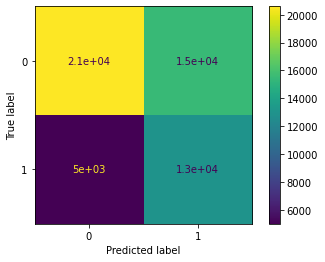

TRAINING DATA ROC SCORE === 0.7079917843198933  ,LEARNING RATE ===  0.1
TESTING DATA ROC SCORE === 0.6466927516158818  ,LEARNING RATE ===  0.1
TRAINING DATA ACCURACY SCORE === 0.7079917843198934  ,LEARNING RATE ===  0.1
TESTING DATA ACCURACY SCORE === 0.621441774491682  ,LEARNING RATE ===  0.1


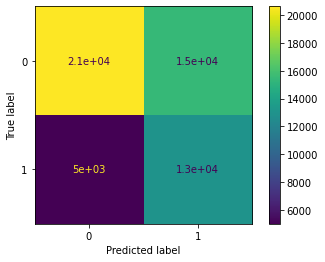

TRAINING DATA ROC SCORE === 0.7080010362119054  ,LEARNING RATE ===  10
TESTING DATA ROC SCORE === 0.6467204524469067  ,LEARNING RATE ===  10
TRAINING DATA ACCURACY SCORE === 0.7080010362119054  ,LEARNING RATE ===  10
TESTING DATA ACCURACY SCORE === 0.6214787430683919  ,LEARNING RATE ===  10


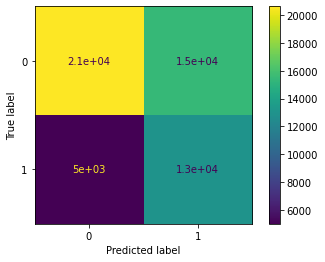

TRAINING DATA ROC SCORE === 0.7079825324278815  ,LEARNING RATE ===  100
TESTING DATA ROC SCORE === 0.6466927516158818  ,LEARNING RATE ===  100
TRAINING DATA ACCURACY SCORE === 0.7079825324278815  ,LEARNING RATE ===  100
TESTING DATA ACCURACY SCORE === 0.621441774491682  ,LEARNING RATE ===  100


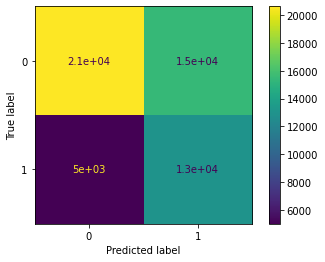

TRAINING DATA ROC SCORE === 0.7079825324278815  ,LEARNING RATE ===  1000
TESTING DATA ROC SCORE === 0.6466927516158818  ,LEARNING RATE ===  1000
TRAINING DATA ACCURACY SCORE === 0.7079825324278815  ,LEARNING RATE ===  1000
TESTING DATA ACCURACY SCORE === 0.621441774491682  ,LEARNING RATE ===  1000


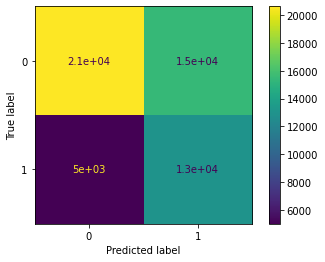

TRAINING DATA ROC SCORE === 0.7079825324278815  ,LEARNING RATE ===  10000
TESTING DATA ROC SCORE === 0.6466927516158818  ,LEARNING RATE ===  10000
TRAINING DATA ACCURACY SCORE === 0.7079825324278815  ,LEARNING RATE ===  10000
TESTING DATA ACCURACY SCORE === 0.621441774491682  ,LEARNING RATE ===  10000


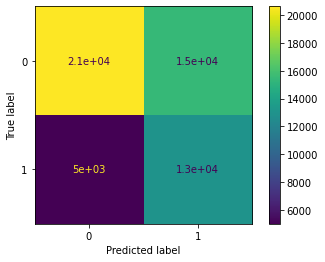

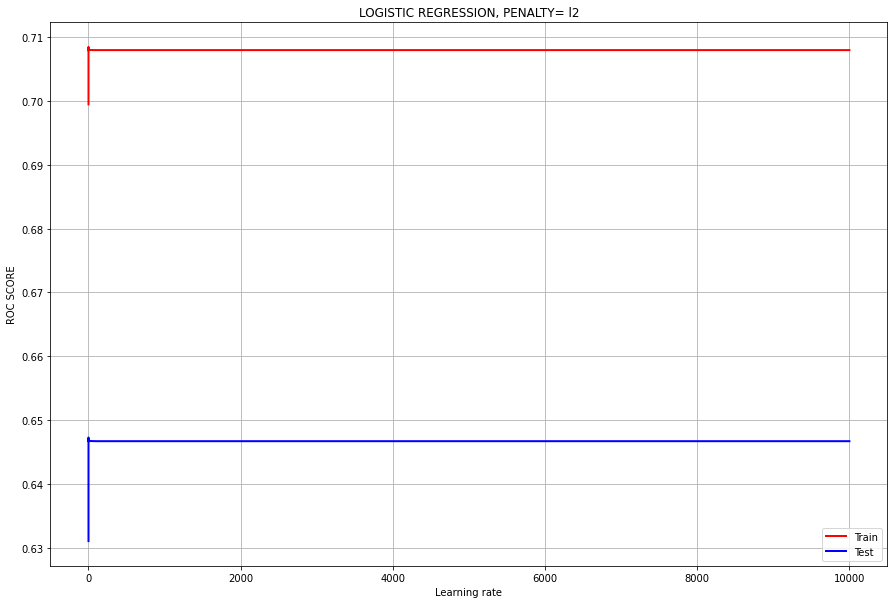

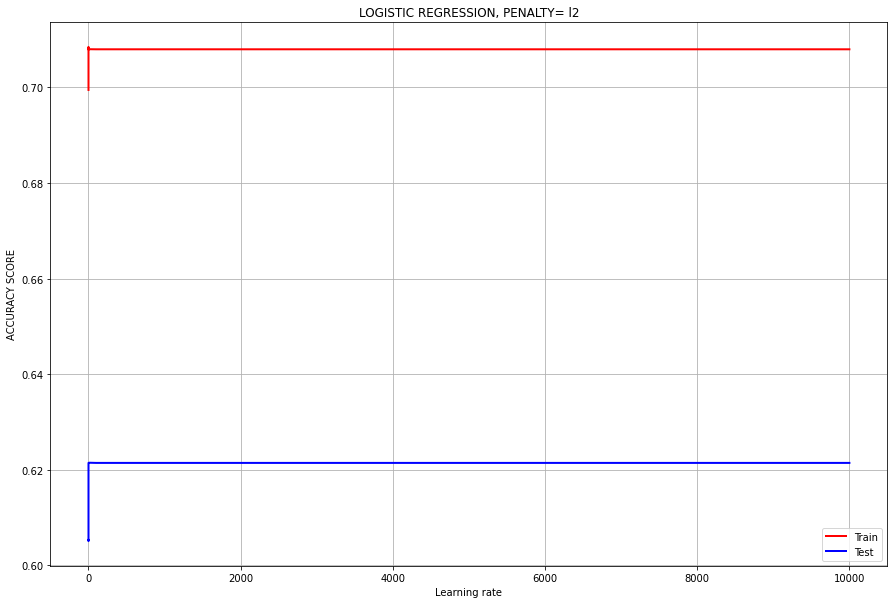

In [125]:
import warnings
warnings.simplefilter("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score
c = [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]
roc_tr = []
roc_test = []
acc_tr = []
acc_test = []
for C in c:
  log = LogisticRegression(penalty='l2', C=C)
  log.fit(x_uns_tr,y_uns_tr)
  roc_tr.append(roc_auc_score(y_uns_tr,log.predict(x_uns_tr)))
  roc_test.append(roc_auc_score(y_test,log.predict(unsampled_test)))
  acc_tr.append(accuracy_score(y_uns_tr,log.predict(x_uns_tr)))
  acc_test.append(accuracy_score(y_test,log.predict(unsampled_test)))
  print('TRAINING DATA ROC SCORE ===', roc_auc_score(y_uns_tr,log.predict(x_uns_tr)), ' ,LEARNING RATE === ',C)
  print('TESTING DATA ROC SCORE ===', roc_auc_score(y_test,log.predict(unsampled_test)), ' ,LEARNING RATE === ',C)
  print('TRAINING DATA ACCURACY SCORE ===', accuracy_score(y_uns_tr,log.predict(x_uns_tr)), ' ,LEARNING RATE === ',C)
  print('TESTING DATA ACCURACY SCORE ===',accuracy_score(y_test,log.predict(unsampled_test)), ' ,LEARNING RATE === ',C)

  plot_confusion_matrix(log,unsampled_test,y_test)
  plt.show()
  print('='*50)

plt.figure(figsize=(15,10))
plt.title('LOGISTIC REGRESSION, PENALTY= l2')
plt.plot(c,roc_tr, linewidth=2, c='red')
plt.plot(c,roc_test, linewidth=2, c='blue')
plt.xlabel('Learning rate')
plt.ylabel('ROC SCORE')
plt.legend(['Train','Test'])
plt.grid(True)
plt.show()
    
plt.figure(figsize=(15,10))
plt.title('LOGISTIC REGRESSION, PENALTY= l2')
plt.plot(c,acc_tr, linewidth=2, c='red')
plt.plot(c,acc_test, linewidth=2, c='blue')
plt.xlabel('Learning rate')
plt.ylabel('ACCURACY SCORE')
plt.legend(['Train','Test'])
plt.grid(True)
plt.show()



<h1>Random Forest Classifier

In [126]:
X = x_uns_tr
Y= y_uns_tr
x = unsampled_test
y = y_test
import warnings
warnings.simplefilter("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
parameters = {'n_estimators':[1,3,5,7,9,11,21,31,51,71,101,201,301,401,501,701,1000],
              'max_depth':[1,3,5,7,9,11,21,31,51,71,101,201,301,401,501,701,1000],
              'class_weight':['balanced', 'balanced_subsample']
              }
clf = RandomizedSearchCV(rf, parameters)
results = clf.fit(X,Y)
results

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [127]:
results.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 3}

In [128]:
pickle.dump([X,Y,x,y],open('/content/drive/MyDrive/Data/training_data.pkl','wb'))

In [129]:
rf_best= RandomForestClassifier(n_estimators=3, max_depth=5,class_weight='balanced')
rf_best.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.6585369344413665
0.6434380776340111


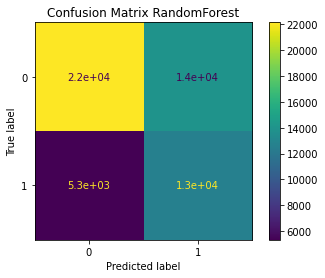

In [130]:
from sklearn.metrics import accuracy_score, roc_auc_score,plot_confusion_matrix
print(roc_auc_score(y,rf_best.predict(x)))
print(accuracy_score(y,rf_best.predict(x)))
plot_confusion_matrix(rf_best,x,y)
plt.title('Confusion Matrix RandomForest')
plt.show()

<h1>Dradient Boosting Algorithm 

In [131]:
import warnings
warnings.simplefilter("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
gbdt= GradientBoostingClassifier()
parameters = {'n_estimators':[1,3,5,7,9,11,21,31,51,71,101,201,301,401,501,701,1000],
              'max_depth':[1,3,5,7,9,11,21,31,51,71,101,201,301,401,501,701,1000],
              'learning_rate':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
              'max_features':['auto', 'sqrt', 'log2'],
              'subsample':[0.5],
              'min_samples_split':[10]
              }
clf = RandomizedSearchCV(gbdt, parameters)
results = clf.fit(X,Y)
results

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                 

In [132]:
results.best_params_

{'learning_rate': 1e-05,
 'max_depth': 31,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 51,
 'subsample': 0.5}

In [133]:
gbdt_best= GradientBoostingClassifier(learning_rate= 1e-05,
 max_depth= 31,
 max_features= 'sqrt',
 min_samples_split= 10,
 n_estimators = 51,
 subsample = 0.5)
gbdt_best.fit(X,Y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1e-05, loss='deviance', max_depth=31,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=51,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

0.6274174361341951
0.6046765249537893


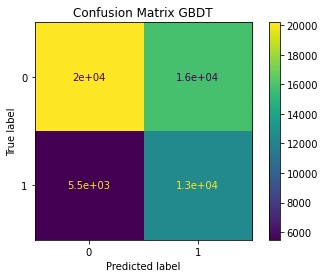

In [134]:
print(roc_auc_score(y,gbdt_best.predict(x)))
print(accuracy_score(y,gbdt_best.predict(x)))
plot_confusion_matrix(gbdt_best,x,y)
plt.title('Confusion Matrix GBDT')
plt.show()

<h1>Decision Tree

TRAINING DATA ROC SCORE === 0.7248302277815813  ,MAX DEPTH ===  3
TESTING DATA ROC SCORE === 0.6436059556786703  ,MAX DEPTH ===  3
TRAINING DATA ACCURACY SCORE === 0.7248302277815813  ,MAX DEPTH ===  3
TESTING DATA ACCURACY SCORE === 0.6001478743068391  ,MAX DEPTH ===  3


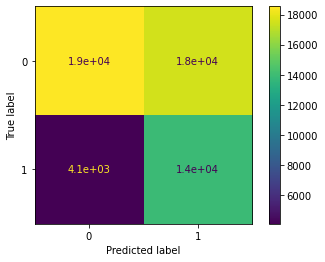

TRAINING DATA ROC SCORE === 0.7352386062949874  ,MAX DEPTH ===  5
TESTING DATA ROC SCORE === 0.6582035241612804  ,MAX DEPTH ===  5
TRAINING DATA ACCURACY SCORE === 0.7352386062949873  ,MAX DEPTH ===  5
TESTING DATA ACCURACY SCORE === 0.6265064695009243  ,MAX DEPTH ===  5


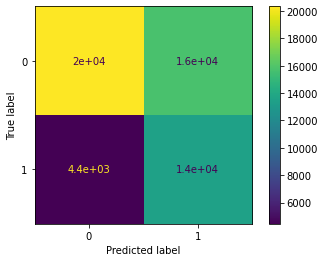

TRAINING DATA ROC SCORE === 0.7398460485169217  ,MAX DEPTH ===  7
TESTING DATA ROC SCORE === 0.6595847953216374  ,MAX DEPTH ===  7
TRAINING DATA ACCURACY SCORE === 0.7398460485169217  ,MAX DEPTH ===  7
TESTING DATA ACCURACY SCORE === 0.6526802218114602  ,MAX DEPTH ===  7


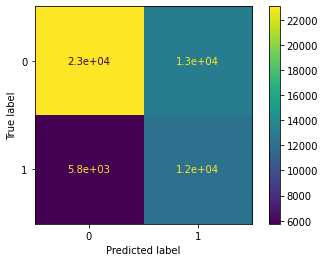

TRAINING DATA ROC SCORE === 0.7444257350628205  ,MAX DEPTH ===  9
TESTING DATA ROC SCORE === 0.6554620652508465  ,MAX DEPTH ===  9
TRAINING DATA ACCURACY SCORE === 0.7444257350628204  ,MAX DEPTH ===  9
TESTING DATA ACCURACY SCORE === 0.6393530499075786  ,MAX DEPTH ===  9


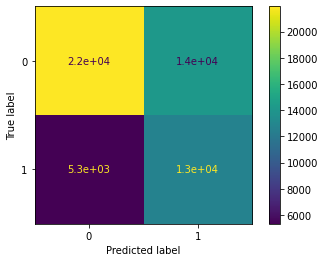

TRAINING DATA ROC SCORE === 0.7471735469903595  ,MAX DEPTH ===  11
TESTING DATA ROC SCORE === 0.6533204062788549  ,MAX DEPTH ===  11
TRAINING DATA ACCURACY SCORE === 0.7471735469903595  ,MAX DEPTH ===  11
TESTING DATA ACCURACY SCORE === 0.6352495378927911  ,MAX DEPTH ===  11


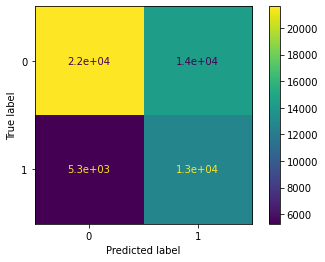

TRAINING DATA ROC SCORE === 0.7511148529874359  ,MAX DEPTH ===  13
TESTING DATA ROC SCORE === 0.6471592797783933  ,MAX DEPTH ===  13
TRAINING DATA ACCURACY SCORE === 0.751114852987436  ,MAX DEPTH ===  13
TESTING DATA ACCURACY SCORE === 0.629815157116451  ,MAX DEPTH ===  13


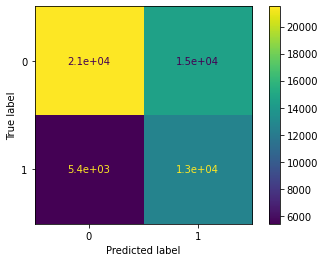

TRAINING DATA ROC SCORE === 0.7561663860259424  ,MAX DEPTH ===  15
TESTING DATA ROC SCORE === 0.635658971991382  ,MAX DEPTH ===  15
TRAINING DATA ACCURACY SCORE === 0.7561663860259423  ,MAX DEPTH ===  15
TESTING DATA ACCURACY SCORE === 0.6188909426987061  ,MAX DEPTH ===  15


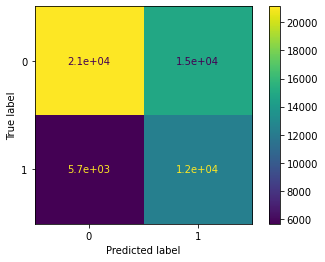

TRAINING DATA ROC SCORE === 0.7609033547360434  ,MAX DEPTH ===  17
TESTING DATA ROC SCORE === 0.6307802400738689  ,MAX DEPTH ===  17
TRAINING DATA ACCURACY SCORE === 0.7609033547360435  ,MAX DEPTH ===  17
TESTING DATA ACCURACY SCORE === 0.6131977818853974  ,MAX DEPTH ===  17


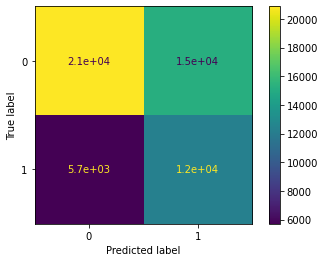

TRAINING DATA ROC SCORE === 0.7636419147715708  ,MAX DEPTH ===  19
TESTING DATA ROC SCORE === 0.6263734995383194  ,MAX DEPTH ===  19
TRAINING DATA ACCURACY SCORE === 0.7636419147715708  ,MAX DEPTH ===  19
TESTING DATA ACCURACY SCORE === 0.6112199630314233  ,MAX DEPTH ===  19


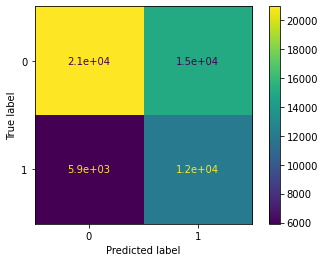

TRAINING DATA ROC SCORE === 0.7649279277612271  ,MAX DEPTH ===  21
TESTING DATA ROC SCORE === 0.6236923668821175  ,MAX DEPTH ===  21
TRAINING DATA ACCURACY SCORE === 0.7649279277612272  ,MAX DEPTH ===  21
TESTING DATA ACCURACY SCORE === 0.6095748613678373  ,MAX DEPTH ===  21


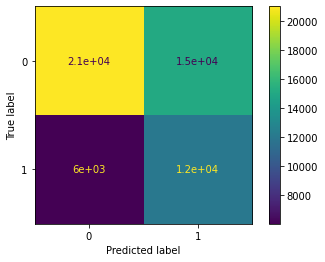

TRAINING DATA ROC SCORE === 0.7653257591177395  ,MAX DEPTH ===  31
TESTING DATA ROC SCORE === 0.6232753924284395  ,MAX DEPTH ===  31
TRAINING DATA ACCURACY SCORE === 0.7653257591177396  ,MAX DEPTH ===  31
TESTING DATA ACCURACY SCORE === 0.6093715341959335  ,MAX DEPTH ===  31


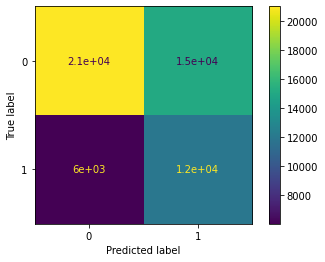

TRAINING DATA ROC SCORE === 0.7653257591177395  ,MAX DEPTH ===  41
TESTING DATA ROC SCORE === 0.6233166358879656  ,MAX DEPTH ===  41
TRAINING DATA ACCURACY SCORE === 0.7653257591177396  ,MAX DEPTH ===  41
TESTING DATA ACCURACY SCORE === 0.6095009242144177  ,MAX DEPTH ===  41


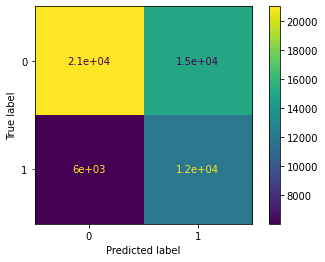

TRAINING DATA ROC SCORE === 0.7653257591177395  ,MAX DEPTH ===  51
TESTING DATA ROC SCORE === 0.6233030932594645  ,MAX DEPTH ===  51
TRAINING DATA ACCURACY SCORE === 0.7653257591177396  ,MAX DEPTH ===  51
TESTING DATA ACCURACY SCORE === 0.6094085027726432  ,MAX DEPTH ===  51


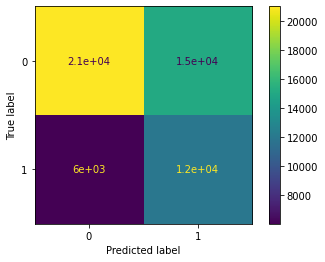

TRAINING DATA ROC SCORE === 0.7653257591177395  ,MAX DEPTH ===  61
TESTING DATA ROC SCORE === 0.6233306401969837  ,MAX DEPTH ===  61
TRAINING DATA ACCURACY SCORE === 0.7653257591177396  ,MAX DEPTH ===  61
TESTING DATA ACCURACY SCORE === 0.6094824399260629  ,MAX DEPTH ===  61


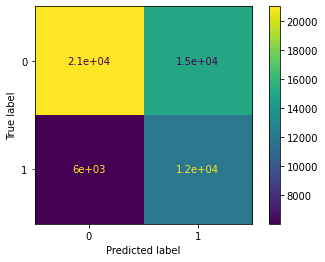

TRAINING DATA ROC SCORE === 0.7653257591177395  ,MAX DEPTH ===  71
TESTING DATA ROC SCORE === 0.6233447214527547  ,MAX DEPTH ===  71
TRAINING DATA ACCURACY SCORE === 0.7653257591177396  ,MAX DEPTH ===  71
TESTING DATA ACCURACY SCORE === 0.609445471349353  ,MAX DEPTH ===  71


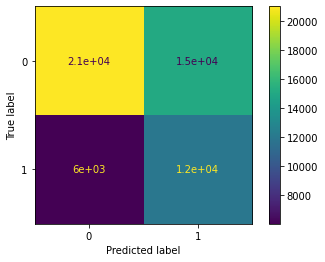

TRAINING DATA ROC SCORE === 0.7653257591177395  ,MAX DEPTH ===  81
TESTING DATA ROC SCORE === 0.623302862419206  ,MAX DEPTH ===  81
TRAINING DATA ACCURACY SCORE === 0.7653257591177396  ,MAX DEPTH ===  81
TESTING DATA ACCURACY SCORE === 0.6094639556377079  ,MAX DEPTH ===  81


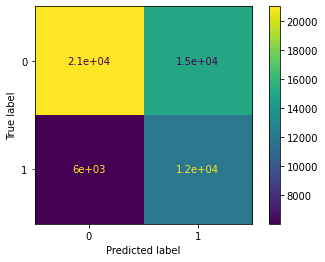

TRAINING DATA ROC SCORE === 0.7653257591177395  ,MAX DEPTH ===  91
TESTING DATA ROC SCORE === 0.6233031702062173  ,MAX DEPTH ===  91
TRAINING DATA ACCURACY SCORE === 0.7653257591177396  ,MAX DEPTH ===  91
TESTING DATA ACCURACY SCORE === 0.6093900184842883  ,MAX DEPTH ===  91


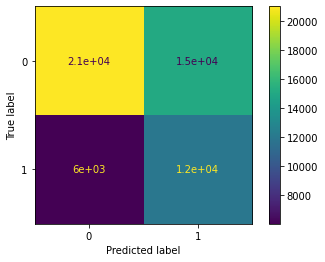

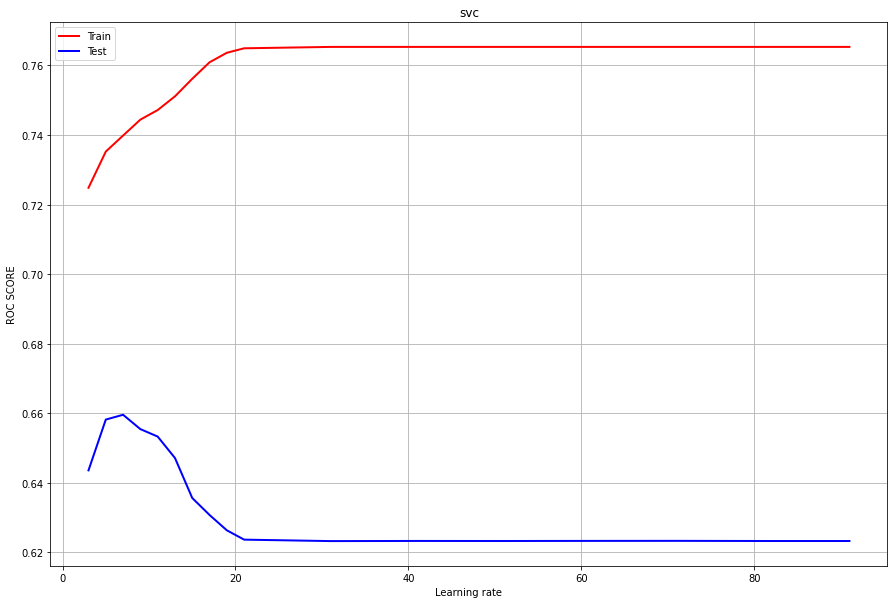

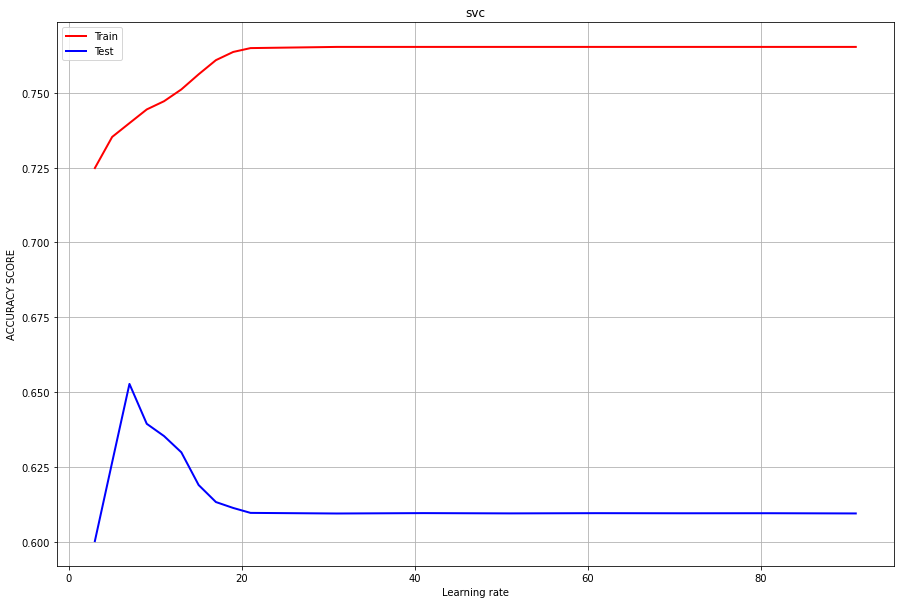

In [135]:
import warnings
warnings.simplefilter("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score
c = [3,5,7,9,11,13,15,17,19,21,31,41,51,61,71,81,91]
roc_tr = []
roc_test = []
acc_tr = []
acc_test = []
for C in c:
  dtree = DecisionTreeClassifier(max_depth=C)
  dtree.fit(X,Y)
  roc_tr.append(roc_auc_score(Y,dtree.predict(X)))
  roc_test.append(roc_auc_score(y,dtree.predict(x)))
  acc_tr.append(accuracy_score(Y,dtree.predict(X)))
  acc_test.append(accuracy_score(y,dtree.predict(x)))
  print('TRAINING DATA ROC SCORE ===', roc_auc_score(Y,dtree.predict(X)), ' ,MAX DEPTH === ',C)
  print('TESTING DATA ROC SCORE ===', roc_auc_score(y,dtree.predict(x)), ' ,MAX DEPTH === ',C)
  print('TRAINING DATA ACCURACY SCORE ===', accuracy_score(Y,dtree.predict(X)), ' ,MAX DEPTH === ',C)
  print('TESTING DATA ACCURACY SCORE ===', accuracy_score(y,dtree.predict(x)), ' ,MAX DEPTH === ',C)

  plot_confusion_matrix(dtree,x,y)
  plt.show()
  print('='*50)

plt.figure(figsize=(15,10))
plt.title('svc')
plt.plot(c,roc_tr, linewidth=2, c='red')
plt.plot(c,roc_test, linewidth=2, c='blue')
plt.xlabel('Learning rate')
plt.ylabel('ROC SCORE')
plt.legend(['Train','Test'])
plt.grid(True)
plt.show()
    
plt.figure(figsize=(15,10))
plt.title('svc')
plt.plot(c,acc_tr, linewidth=2, c='red')
plt.plot(c,acc_test, linewidth=2, c='blue')
plt.xlabel('Learning rate')
plt.ylabel('ACCURACY SCORE')
plt.legend(['Train','Test'])
plt.grid(True)
plt.show()

pickle.dump(dtree,open('/content/drive/MyDrive/Data/dtree.pkl','wb'))
#Dtree = pickle.load(open('/content/drive/MyDrive/Data/Dtree.pkl','rb'))

<h1>Prediction

In [ ]:
sample = pd.read_csv('/content/sample_submission_eyYijxG.csv')
sample

In [137]:
test_data = pd.read_csv('/content/test_mSzZ8RL.csv')
test_data

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No
...,...,...,...,...,...,...,...,...,...,...
105307,DBENJOYI,Male,52,RG268,Salaried,X2,86,Yes,4242558,Yes
105308,CWQ72DWS,Male,55,RG277,Other,X2,86,Yes,1159153,No
105309,HDESC8GU,Male,35,RG254,Salaried,X4,15,No,1703727,No
105310,2PW4SFCA,Male,53,RG254,Other,X3,93,No,737178,Yes


In [138]:
sub_data = test_data.copy()

In [159]:
Occupation_idf_sub

array([5.86231706, 2.26785775, 2.1616744 , 1.92157884])

In [164]:
Channel_Code_idf_sub

array([1.76641992, 2.35710669, 2.36542324, 4.78681166])

In [163]:
Is_Active_idf_sub

array([1.47213651, 1.97726816])

In [162]:
Occupation_sub, Occupation_features_sub, Occupation_idf_sub = tfidf(sub_data['Occupation'], X_tr['Occupation'])
Channel_Code_sub, Channel_Code_features_sub, Channel_Code_idf_sub = tfidf(sub_data['Channel_Code'], X_tr['Channel_Code'])
Is_Active_sub, Is_Active_features_sub, Is_Active_idf_sub = tfidf(sub_data['Is_Active'], X_tr['Is_Active'])


age_normal_sub = normalize(sub_data, X_tr, 'Age')
vin_normal_sub = normalize(sub_data, X_tr, 'Vintage')


sub_data_vec = np.column_stack((
                          Occupation_sub,
                          Channel_Code_sub, 
                          Is_Active_sub,
                          age_normal_sub,
                          vin_normal_sub
                         ))
                        

In [230]:
pickle.dump(X_tr,open('/content/sample_data/X_tr.pkl','wb'))
pickle.dump([scaler.mean_,scaler.var_],open('/content/sample_data/mean_var_age_and_vintage_list.pkl','wb'))

In [142]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_uns_tr)
sub_data_vec = scaler.transform(sub_data_vec)

<h1>INFERENCE

In [143]:
sample_tree = sample.copy()

<h3>Using GBDT

In [149]:
pred_test = gbdt_best.predict(sub_data_vec)
sample_tree['Is_Lead'] = pred_test
sample_tree.to_csv('/content/sample_data/gbdt_best_5.csv', index=False)

In [150]:
pred_test = pd.DataFrame(pred_test,columns=['pred'])
pred_test[pred_test['pred']==1].count()

pred    64132
dtype: int64

<h3>Using Random Forest

In [146]:
pred_test = rf_best.predict(sub_data_vec)
sample_tree['Is_Lead'] = pred_test
sample_tree.to_csv('/content/sample_data/rf_best_5.csv', index=False)

In [ ]:
pred_test = pd.DataFrame(pred_test,columns=['pred'])
pred_test[pred_test['pred']==1].count()

pred    15404
dtype: int64

<h3>Using Decision Tree Classifier

In [151]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=7)
tree.fit(X,Y)
pred_test = tree.predict(sub_data_vec)
sample_tree['Is_Lead'] = pred_test
sample_tree.to_csv('/content/sample_data/Dtree_5.csv', index=False)

In [152]:
pred_test = pd.DataFrame(pred_test,columns=['pred'])
pred_test[pred_test['pred']==1].count()

pred    65832
dtype: int64

<h1>Saving Models to system

In [153]:
pickle.dump(rf_best,open('/content/sample_data/rf_best_model.pkl','wb'))
pickle.dump(gbdt_best,open('/content/sample_data/gbdt_best_model.pkl','wb'))
pickle.dump(tree,open('/content/sample_data/dtree_best_model.pkl','wb'))

<h1>User Input Inference

In [ ]:
def predict(classifier,occupation,channel,is_active,age,vintage_month):
  inp0 = pd.DataFrame([occupation],columns = ['Occupation'])
  inp1 = pd.DataFrame([channel],columns = ['Channel_Code'])
  inp2 = pd.DataFrame([is_active],columns = ['Is_Active'])


  inp00,_,_ = tfidf(inp0['Occupation'], X_tr['Occupation'])
  inp10,_,_ = tfidf(inp1['Channel_Code'], X_tr['Channel_Code'])
  inp20,_,_ = tfidf(inp2['Is_Active'], X_tr['Is_Active'])

  u_inp =  np.column_stack((
                            inp00,
                            inp10, 
                            inp20
                          ))
  u_inp_c = np.append(np.array(u_inp),[[age],[vintage_month]])
  for i,mean in enumerate(scaler.mean_):
    u_inp_c[i] -= mean /  np.sqrt(scaler.var_[i])

  pred = classifier.predict(u_inp_c.reshape(-1,1).T)[0]

  return pred